<a href="https://colab.research.google.com/github/juliancramos/cnn-pneumonia-covid-detector/blob/main/cnn_pneumonia_covid_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chest X-Ray Classification: Normal vs. Pneumonia vs. COVID-19

**Authors:** Sergio Ortíz - Julián Ramos - Melissa Ruíz

**Course:** Machine Learning Techniques

**Date:** February 2026

## 1. Executive Summary
Lung diseases such as Pneumonia and COVID-19 are critical health conditions requiring timely diagnosis. Traditional manual interpretation of chest X-rays is subjective and prone to error.

This project aims to develop an automated Deep Learning system using **Convolutional Neural Networks (CNNs)** to classify chest X-ray images into three categories:
1.  **Normal**
2.  **Pneumonia**
3.  **COVID-19**

---
### 1.1 Project Objectives
This project follows a structured workflow designed to meet specific technical requirements:

1.  **Exploratory Data Analysis (EDA):**
    * Explore the dataset to identify key characteristics, including class distribution and image quality.
    * Detect potential biases (e.g., class imbalance) and present visualizations to support design decisions.

2.  **Image Preprocessing:**
    * Implement techniques to improve input quality, such as pixel normalization and resizing.
    * Apply **Data Augmentation** strategies to improve model generalization and prevent overfitting.
    * Justify how these steps prepare the data for the neural network.

3.  **Neural Network Design:**
    * Design a custom **Convolutional Neural Network (CNN)** architecture suitable for classification.
    * Justify the selection of layers (Convolutional, Pooling, Fully Connected), filter sizes, and activation functions.
    * Present the architecture diagram and explain its expected behavior.

4.  **Training and Evaluation:**
    * Train the model using an appropriate optimization strategy and loss function.
    * Evaluate performance on a validation set using robust metrics such as **Precision, Recall, and F1-Score**.
    * Analyze results to identify issues like overfitting and propose technical solutions.

## 2. Environment Setup and Configuration

In this section, the execution environment is configured.

### 2.1 Technical Stack
* **Data Manipulation:** `pandas` and `numpy` are utilized for metadata handling and numerical operations.
* **Visualization:** `matplotlib` and `seaborn` are employed to analyze data distributions and training metrics.
* **Image Processing:** `cv2` (OpenCV) is used for reading and resizing X-ray images.
* **Deep Learning:** `tensorflow` and `keras` serve as the core framework for constructing the CNN.



In [ ]:
import os
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf

# CONSTANTS CONFIGURATION
# Fixed seed to ensure reproducibility (weights)
SEED = 42
# Target image resolution (224x224 pixels)
IMG_SIZE = 224
# Number of images processed per iteration
BATCH_SIZE = 32

def set_seed(seed_value):
    """
    Sets the random seed for reproducibility across all libraries.

    This function locks the pseudo-random number generators of Python, NumPy,
    and TensorFlow to a specific sequence.

    Args:
        seed_value (int): The seed number to initialize generators.
    """
    # Python's built-in hashing (dictionaries/sets)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

    # Python's standard random library (shuffle, choice)
    random.seed(seed_value)

    # NumPy's random module (array splitting, matrices)
    np.random.seed(seed_value)

    # TensorFlow's random module (weight initialization)
    tf.random.set_seed(seed_value)

# Apply the configuration
set_seed(SEED)

# Visualization Setup
# Set a style for all plots (background grid)
sns.set_style("whitegrid")

# Define a global figure size (12x6 inches)
plt.rcParams['figure.figsize'] = (12, 6)

# Silence non-critical alerts (DeprecationWarnings)
warnings.filterwarnings('ignore')

print("Environment setup complete.")
print(f"TensorFlow Version: {tf.__version__}")

Environment setup complete.
TensorFlow Version: 2.19.0


## 3. Data Ingestion

In this section, the required datasets are downloaded from Kaggle.

The Kaggle API (`kaggle.json`) is utilized because the dataset consists of **unstructured image data** organized in directory trees, rather than structured tabular files (e.g., CSV or Excel).
**Datasets acquired:**
* **Chest X-Ray Images (Pneumonia):** provided by Paul Mooney.
* **COVID-19 Radiography Database:** provided by Tawsifur Rahman.

In [ ]:
import os
from google.colab import drive

def setup_kaggle_from_drive():
    """
    Configures the Kaggle API by loading the token from Google Drive.

    This function mounts the user's Google Drive, looks for 'kaggle.json'
    in the root directory ('/content/drive/MyDrive/'), and download the datasets.
    """

    # Validate if data already exists
    if os.path.exists('chest_xray') and os.path.exists('COVID-19_Radiography_Dataset'):
        print("Data already exists. Skipping download and extraction.")
        return

    # Mount Google Drive
    print("Mounting Google Drive...")
    drive.mount('/content/drive')

    # Path to the token in Drive
    drive_path = '/content/drive/MyDrive/kaggle.json'
    #local_path = '/root/.kaggle/kaggle.json'

    # Check and Copy Credentials
    if not os.path.exists(drive_path):
        print(f"Error: 'kaggle.json' not found at {drive_path}.")
        print("Upload the file to your Google Drive root folder.")
        return

    # Create the hidden directory .kaggle
    !mkdir -p ~/.kaggle

    # Copy the file from Drive to the local Colab environment
    !cp "$drive_path" ~/.kaggle/

    # Set security permissions (Required by Kaggle API)
    !chmod 600 ~/.kaggle/kaggle.json
    print("API Token loaded from Drive successfully.")

    # Dataset Download & Extraction
    print("\nDownloading Datasets...")

    print("Downloading Chest X-Ray Images (Pneumonia)...")
    !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia --force

    print("Downloading COVID-19 Radiography Database...")
    !kaggle datasets download -d tawsifurrahman/covid19-radiography-database --force

    print("\nExtracting Files...")
    # Unzip
    !unzip -qo chest-xray-pneumonia.zip
    !unzip -qo covid19-radiography-database.zip

    print("SUCCESS: Data ingestion complete.")

# Execute the function
setup_kaggle_from_drive()

Data already exists. Skipping download and extraction.


## 4. Data Processing
The data comes from two different sources with distinct directory structures. In this section, it is unified into a single DataFrame.

**Process:**
1.  **Cleanup:** Remove temporary `.zip` files to free up disk space.
2.  **Path Extraction:** Traverse the directory trees of both datasets.
3.  **Labeling:** Assign standardized labels (`COVID-19`, `NORMAL`, `PNEUMONIA`) based on the folder source.
4.  **Consolidation:** Create a Pandas DataFrame containing all file paths and labels for easy manipulation.

### 4.1 Initialization and Environment Cleanup
Before processing, the environment is prepared by importing necessary libraries ( `pathlib`, `os`). Additionally, the source `.zip` archives are removed from the working directory to release disk space.

Global lists `image_paths` and `labels` are initialized here to serve as the accumulators for the subsequent data extraction steps.

In [ ]:
import os
from pathlib import Path

# Remove source zip files to save space
if os.path.exists('chest-xray-pneumonia.zip'):
    !rm *.zip
    print("Temporary zip files removed.")

# Initialize storage for the unified dataset
image_paths = []
labels = []

### 4.2 Processing COVID-19 Radiography Dataset
This dataset is organized into four distinct folders: `COVID`, `Normal`, `Lung_Opacity`, and `Viral Pneumonia`.

**Class Selection:**

1.  **`COVID` (Selected):** Represents the positive class for the detection target.
2.  **`Normal` (Selected):** These images are included to supplement the `NORMAL` class from the second dataset. Combining healthy samples from both sources.
3. **`Lung_Opacity` (Excluded):** This folder is removed. “Lung Opacity” is a general label that can point to pneumonia, pulmonary edema, lung cancer, or other issues. Keeping it as a separate class from “Pneumonia” or “COVID-19” would add ambiguity.

4. **`Viral Pneumonia` (Included):** This folder is included and merged into the general `PNEUMONIA` class. By incorporating these 1,345 additional samples, the diversity of the pneumonia dataset is increased.

In [ ]:
# COVID-19 Radiography Dataset
# Extract 'COVID' and 'Normal'
print("Processing COVID-19 Radiography Dataset...")

# Class: COVID-19
covid_path = Path("COVID-19_Radiography_Dataset/COVID/images")
covid_files = list(covid_path.glob('*.*')) #any file type
image_paths.extend([str(path) for path in covid_files])
labels.extend(['COVID-19'] * len(covid_files))
print(f"-> Added {len(covid_files)} COVID-19 images.")

# Class: Normal
normal_covid_path = Path("COVID-19_Radiography_Dataset/Normal/images")
normal_covid_files = list(normal_covid_path.glob('*.*'))
image_paths.extend([str(path) for path in normal_covid_files])
labels.extend(['NORMAL'] * len(normal_covid_files))
print(f"-> Added {len(normal_covid_files)} Normal images from COVID-19 dataset")

# Class: Viral Pneumonia
# These images are added to the PNEUMONIA label to increase its sample size
viral_pneumo_path = Path("COVID-19_Radiography_Dataset/Viral Pneumonia/images")
viral_files = list(viral_pneumo_path.glob('*.*'))
image_paths.extend([str(path) for path in viral_files])
labels.extend(['PNEUMONIA'] * len(viral_files))
print(f"-> Added {len(viral_files)} Viral Pneumonia images to the PNEUMONIA class.")

Processing COVID-19 Radiography Dataset...
-> Added 3616 COVID-19 images.
-> Added 10192 Normal images from COVID-19 dataset
-> Added 1345 Viral Pneumonia images to the PNEUMONIA class.


### 4.3 Processing Chest X-Ray (Pneumonia) Dataset
This dataset follows a standard machine learning directory structure, split into `train`, `test`, and `val` folders, each containing subdirectories for `PNEUMONIA` and `NORMAL`.

**Extraction Strategy:**
Since the goal is to create a unified DataFrame for a custom split later, the code ignores the original pre-split structure. An iteration is performed over all subdirectories (`train`, `test`, `val`) to aggregate every image into a list.



In [ ]:
# Chest X-Ray (Pneumonia) Dataset
print("\n--- Processing Chest X-Ray (Pneumonia) Dataset ---")
pneumonia_path = Path("chest_xray")

# Initialize counters
count_normal = 0
count_pneumonia = 0

# Loop through the training, testing, and validation folders
for split in ['train', 'test', 'val']:
    # Loop through both classes inside each folder
    for class_name in ['NORMAL', 'PNEUMONIA']:
        class_path = pneumonia_path / split / class_name

        # Search for all possible image extensions to avoid missing any files
        files = list(class_path.glob('*.jpeg')) + \
                list(class_path.glob('*.jpg')) + \
                list(class_path.glob('*.png'))

        # Add them to the main lists
        image_paths.extend([str(path) for path in files])
        labels.extend([class_name] * len(files))

        # Update specific counters
        if class_name == 'NORMAL':
            count_normal += len(files)
        elif class_name == 'PNEUMONIA':
            count_pneumonia += len(files)

        print(f"-> Added {len(files)} images for class '{class_name}' from '{split}' set.")

# Final report for this specific source
print(f"-> Processed all images from Chest X-Ray source.")
print(f"   - Total PNEUMONIA added: {count_pneumonia}")
print(f"   - Total NORMAL added:    {count_normal}")


--- Processing Chest X-Ray (Pneumonia) Dataset ---
-> Added 1341 images for class 'NORMAL' from 'train' set.
-> Added 3875 images for class 'PNEUMONIA' from 'train' set.
-> Added 234 images for class 'NORMAL' from 'test' set.
-> Added 390 images for class 'PNEUMONIA' from 'test' set.
-> Added 8 images for class 'NORMAL' from 'val' set.
-> Added 8 images for class 'PNEUMONIA' from 'val' set.
-> Processed all images from Chest X-Ray source.
   - Total PNEUMONIA added: 4273
   - Total NORMAL added:    1583


### 4.4 DataFrame Consolidation and Shuffling
Finally, the accumulated file paths and their corresponding labels are merged into a Pandas DataFrame.

**Data Shuffling:**

Here, the DataFrame is shuffled (`sample(frac=1)`). When the data is first loaded, the images are grouped by class (for example, all COVID images first, then Normal, then Pneumonia). If the model is trained in that same order, it could struggle to learn properly and end up focusing on one class at a time.

By randomizing the order, each training batch contains a mix of different classes.


In [ ]:
# Create DataFrame
df = pd.DataFrame({'filepath': image_paths, 'label': labels})

# Apply shuffling to ensure the model does not learn the order of classes
# .sample(frac=1): Shuffles the dataset by returning 100% of the rows in random order.
# random_state=42: Sets a fixed seed to guarantee the random results are reproducible.
# .reset_index(drop=True): Re-indexes the rows from 0 to N.
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"DataFrame Created. Total Samples: {len(df)}")
print("-" * 50)
print(df['label'].value_counts())
print("-" * 50)
display(df.head())

DataFrame Created. Total Samples: 21009
--------------------------------------------------
label
NORMAL       11775
PNEUMONIA     5618
COVID-19      3616
Name: count, dtype: int64
--------------------------------------------------


,filepath,label
0,COVID-19_Radiography_Dataset/Normal/images/Nor...,NORMAL
1,COVID-19_Radiography_Dataset/Normal/images/Nor...,NORMAL
2,COVID-19_Radiography_Dataset/COVID/images/COVI...,COVID-19
3,COVID-19_Radiography_Dataset/Normal/images/Nor...,NORMAL
4,COVID-19_Radiography_Dataset/Normal/images/Nor...,NORMAL


## 5. Exploratory Data Analysis (EDA)

This stage examines the dataset to understand its structure and quality before moving on to modeling. The goal is to ensure that the data is consistent and that the labels align with the visual features of the medical images.

**The main objectives of this EDA are:**

1. **Class Distribution:** Identify class imbalances and consider their potential impact on model training.  
2. **Image Quality and Integrity:** Check for blurry images, artifacts, or source-specific patterns.  
3. **Image Size Analysis:** Review image resolutions.


### 5.1 Quantitative Analysis: Class Distribution

The dataset is analyzed to see how many images belong to each class: `NORMAL`, `PNEUMONIA`, and `COVID-19`. Understanding these proportions helps guide decisions for the training process.

* **Effect on Model Training:** Large differences in class sizes can make the model favor the majority class (`NORMAL`), which could reduce its ability to learn features from the less-represented classes.  
* **Choosing Performance Metrics:** When classes are imbalanced, overall accuracy may not be enough. This analysis supports using metrics like F1-Score and Precision-Recall for a clearer picture.  
* **Basis for Balancing Techniques:** The class distribution justifies applying strategies such as class weighting, targeted data augmentation, or undersampling during pre-process*


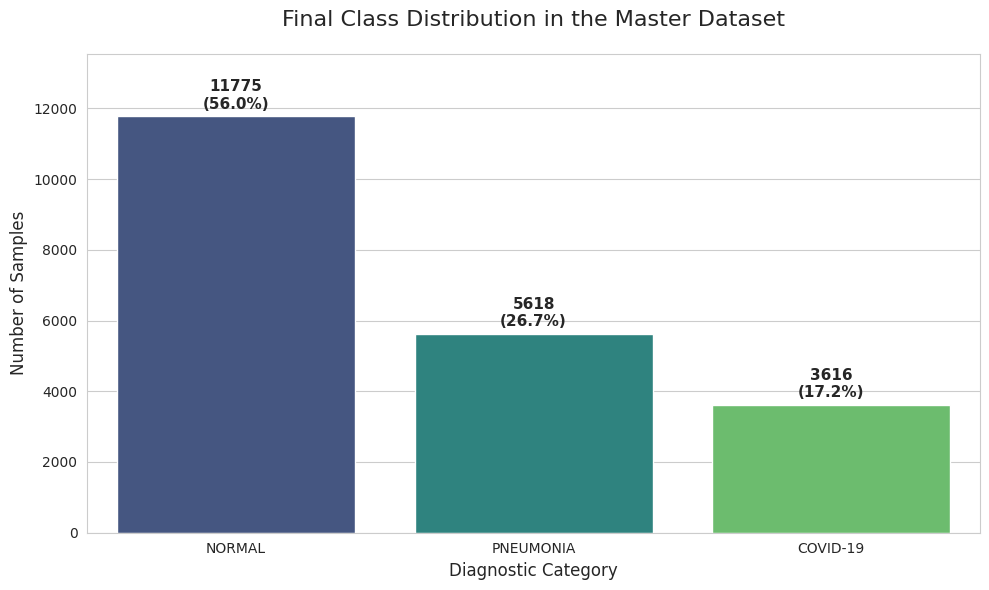

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_class_distribution(dataframe):
    """
    Generates a bar chart to visualize the distribution of classes in the dataset.
    """

    # Calculate counts and percentages
    counts = dataframe['label'].value_counts()
    percentages = (counts / len(dataframe)) * 100

    # Set the visual style
    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")

    # Create the bar plot
    order = ['NORMAL', 'PNEUMONIA', 'COVID-19']
    ax = sns.countplot(x='label', data=dataframe, palette='viridis',
                       order=order)

    # Title and Labels
    plt.title('Final Class Distribution in the Master Dataset',
              fontsize=16, pad=20)
    plt.xlabel('Diagnostic Category', fontsize=12)
    plt.ylabel('Number of Samples', fontsize=12)

    # Annotate bars with counts and percentages
    for i, p in enumerate(ax.patches):
        label_count = int(counts[order[i]])
        label_pct = percentages[order[i]]

        # Display text on top of each bar
        ax.annotate(f'{label_count}\n({label_pct:.1f}%)',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center',
                    xytext = (0, 15),
                    textcoords = 'offset points',
                    fontsize=11, fontweight='bold')

    # Adjust layout to prevent clipping of labels
    plt.ylim(0, max(counts) * 1.15)
    plt.tight_layout()
    plt.show()

# Execute the visualization
plot_class_distribution(df)

### Analysis of Results

The dataset contains a total of 21,009 images, distributed as follows:

* **NORMAL:** 11,775 samples (56.0%)  
* **PNEUMONIA:** 5,618 samples (26.7%)  
* **COVID-19:** 3,616 samples (17.2%)  

The distribution shows a clear class imbalance, with `NORMAL` having more images than the other two classes combined. This imbalance can cause the model to lean toward healthy samples during training. To address this, techniques like **image augmentation** and **class weighting** will be applied to balance the learning process.


### 5.2 Qualitative Analysis: Visual Inspection

In this section, a random sample of images from the `NORMAL`, `PNEUMONIA`, and `COVID-19` categories is displayed. The purpose of this visual check is to evaluate the dataset quality before the training phase begins. This inspection focuses on:

* **Label Integrity:** Confirming that the anatomical patterns in the X-rays correspond to their assigned diagnostic labels.
* **Identification of Artifacts:** Searching for external elements such as medical equipment (cables, electrodes) or text markers ('R', 'L') that could introduce bias into the model.
* **Visual Consistency:** Observing differences in brightness, contrast, and resolution across the different data sources to define pre-processing requirements.

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os

def visualize_samples(dataframe, categories, samples_per_category=5):
    """
    Displays a grid of random images for each specified category.

    Args:
        dataframe (pd.DataFrame): The master dataset containing file paths.
        categories (list): List of label names to visualize
        samples_per_category (int): Number of images to show per class.
    """

    # Calculate grid size: Rows = number of classes, Cols = samples per class
    n_rows = len(categories)
    n_cols = samples_per_category

    # Create the figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
    plt.subplots_adjust(wspace=0.1, hspace=0.1)

    for i, category in enumerate(categories):
        # Filter the dataframe for the specific class
        class_df = dataframe[dataframe['label'] == category]

        # Take a random sample
        #Try-except block in case a class has fewer images than requested
        try:
            random_samples = class_df.sample(samples_per_category, random_state=42)
        except ValueError:
            random_samples = class_df # Take all if fewer than requested

        for j, (_, row) in enumerate(random_samples.iterrows()):
            img_path = row['filepath']

            # Read image using OpenCV
            img = cv2.imread(img_path)

            if img is not None:
                # Convert from BGR to RGB
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # Determine current subplot axis
                if n_rows > 1:
                    ax = axes[i, j]
                else:
                    ax = axes[j] # Handle case if only 1 category is requested

                # Display image
                ax.imshow(img)
                ax.axis('off') # Hide axes ticks

                # Set title only on the first image of the row
                if j == 0:
                    ax.set_title(f"{category}", fontsize=14, fontweight='bold', pad=10, loc='left')
            else:
                print(f"Could not read image at {img_path}")

    plt.show()

Generating visual inspection grid...


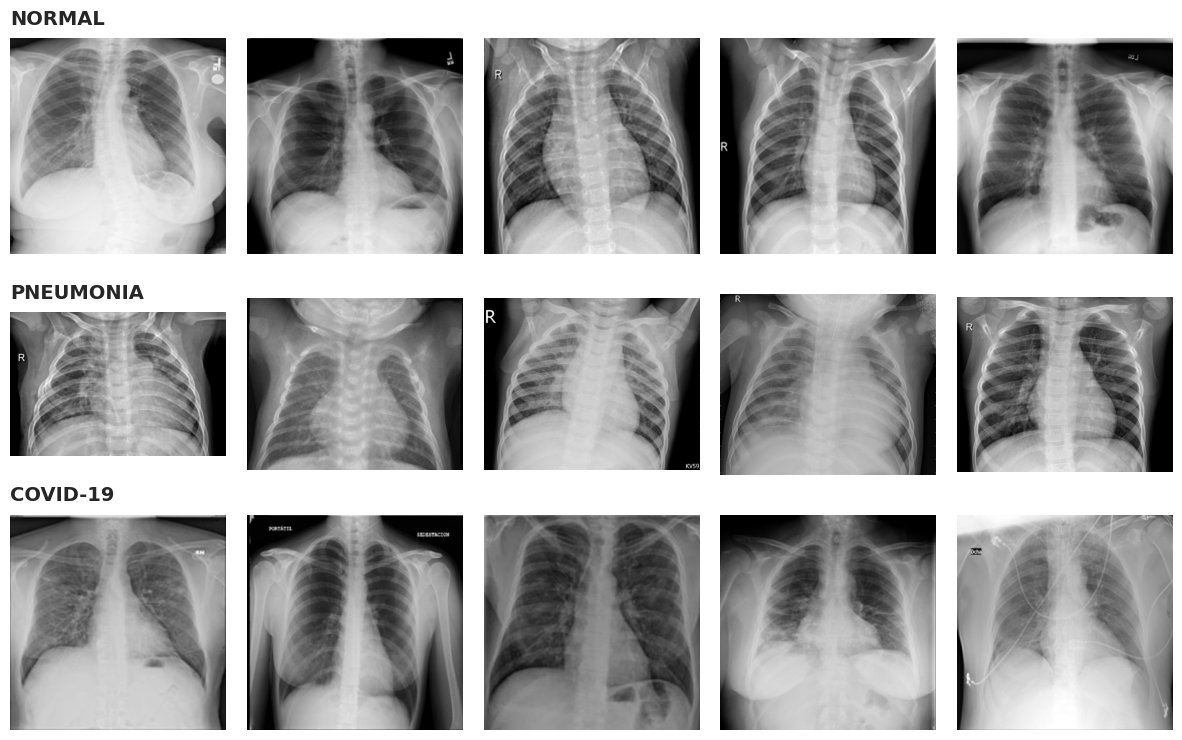

In [ ]:
# Define the order of categories to inspect
target_categories = ['NORMAL', 'PNEUMONIA', 'COVID-19']

# Execute the visualization function
print("Generating visual inspection grid...")
visualize_samples(df, target_categories, samples_per_category=5)

### Analysis of Visual Inspection

The review of random samples shows noticeable variability in the images, which points to specific pre-processing needs:

* **Inconsistent Dimensions:** Images have different sizes and shapes, with some being square and others rectangular. All images need to be resized to a standard size of 224x224 pixels before feeding them into the neural network.  
* **Presence of Artifacts:** Some X-rays include medical annotations such as 'R' or 'L', or monitoring equipment like ECG leads and wires, especially in pathological cases. These features could bias the model, which should focus only on lung patterns.  
* **Intensity Variations:** Images differ in brightness and contrast. Some appear faint and low-contrast, while others are clearer. Pixel values should be normalized to a 0-1 range to support stable training.


### 5.3 Quantitative Analysis: Image Dimensions

A statistical analysis of image resolutions is conducted to define the most appropriate input size for the neural network. Due to the dataset combines images from two different datasets, variation in dimensions is expected.

**Objective:**

* **Analyze Resolution Distribution:** Use a scatter plot of width vs height to identify the most common image sizes.  
* **Assess Aspect Ratios:** Determine whether images are mostly square or rectangular.


#### Statistical Distribution of Resolutions

The following analysis is performed on a random sample of the dataset to characterize the image geometry:

1.  **Scatter Plot (Width vs. Height):** Visualizes the relationship between image dimensions to identify dominant aspect ratios (square vs. rectangular) and compares them against the target input size ($224 \times 224$).
2.  **Frequency Tables:** Categorizes images into resolution ranges to quantify the distribution per class.

Sampling 1000 images for dimensional analysis...
Average Width: 560
Average Height: 473

FREQUENCY TABLE: WIDTH RANGES
label        COVID-19  NORMAL  PNEUMONIA
Width_Range                             
0-500             166     520         66
501-1000            0       0         37
1001-1500           0      25        105
1501-2000           0      47         24
2001-3000           0       8          2

FREQUENCY TABLE: HEIGHT RANGES
label         COVID-19  NORMAL  PNEUMONIA
Height_Range                             
0-500              166     520         79
501-1000             0       8        113
1001-1500            0      48         37
1501-2000            0      22          5
2001-3000            0       2          0


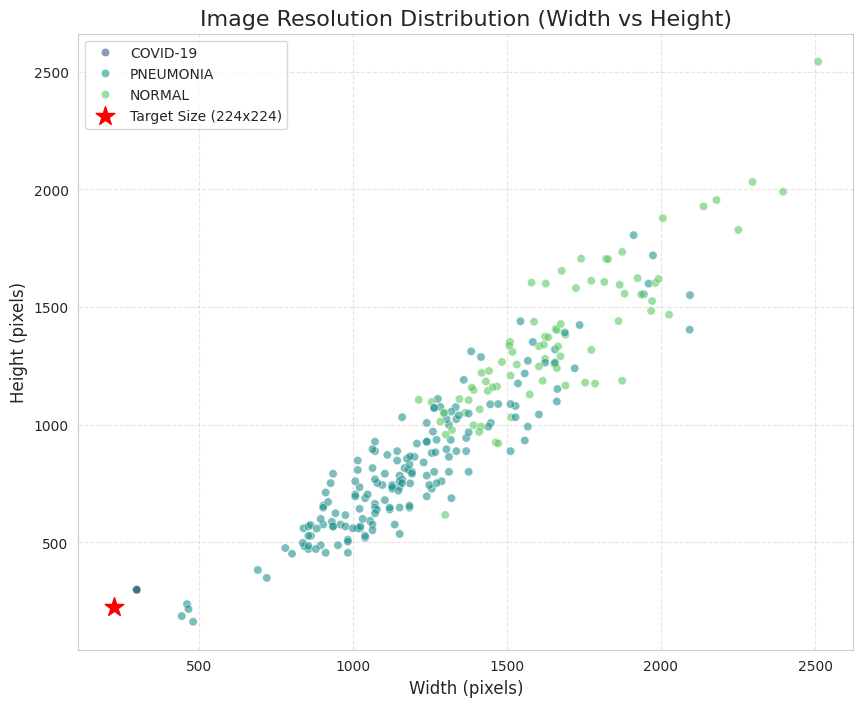

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cv2
import numpy as np

def analyze_dimensions(dataframe, sample_size=1000):
    """
    Generates an Scatter Plot (Width vs Height).
    Calculates and prints Mean Dimensions.
    Prints Frequency Tables for ranges.
    """
    print(f"Sampling {sample_size} images for dimensional analysis...")

    # Sampling
    if len(dataframe) > sample_size:
        sample_df = dataframe.sample(sample_size, random_state=42)
    else:
        sample_df = dataframe

    data = []

    # 2. Data Extraction
    for _, row in sample_df.iterrows():
        try:
            img = cv2.imread(row['filepath'])
            if img is not None:
                h, w, _ = img.shape
                data.append({
                    'label': row['label'],
                    'width': w,
                    'height': h
                })
        except Exception:
            pass # Skip corrupted

    stats_df = pd.DataFrame(data)


    # Average width and height
    avg_w = int(stats_df['width'].mean())
    avg_h = int(stats_df['height'].mean())
    print(f"Average Width: {avg_w}")
    print(f"Average Height: {avg_h}")


    # Frequency table
    ranges = [0, 500, 1000, 1500, 2000, 3000, 5000]
    labels = ['0-500', '501-1000', '1001-1500', '1501-2000', '2001-3000', '3000+']

    stats_df['Width_Range'] = pd.cut(stats_df['width'],
                                     bins=ranges, labels=labels)
    stats_df['Height_Range'] = pd.cut(stats_df['height'],
                                      bins=ranges, labels=labels)

    print("\n" + "="*40)
    print("FREQUENCY TABLE: WIDTH RANGES")
    print("="*40)
    print(pd.crosstab(stats_df['Width_Range'], stats_df['label']))

    print("\n" + "="*40)
    print("FREQUENCY TABLE: HEIGHT RANGES")
    print("="*40)
    print(pd.crosstab(stats_df['Height_Range'], stats_df['label']))



    # Scatter plot
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=stats_df, x='width', y='height', hue='label',
                    alpha=0.6, palette='viridis')

    # Target marker
    plt.scatter([224], [224], color='red', s=200, marker='*',
                label='Target Size (224x224)')

    plt.title('Image Resolution Distribution (Width vs Height)', fontsize=16)
    plt.xlabel('Width (pixels)', fontsize=12)
    plt.ylabel('Height (pixels)', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

    return stats_df

# Execute
stats_data = analyze_dimensions(df)

### Analysis of Dimensional Results

The scatter plot and frequency tables show how image sizes are distributed and highlight an important detail in the visualization:

* **Square Aspect Ratio:** Most data points follow the pattern width = height, which shows that the majority of images are square.

* **Overplotting Effect:** The scatter plot seems to show many high-resolution images (above 1500 pixels) because those points are more spread out and easier to notice. However, the average values (width = 563, height = 475) indicate that most images are smaller. This happens because many low-resolution images overlap in the lower-left area of the plot (0–500 range), forming a dense cluster that looks small but actually contains many samples.

* **Class–Resolution Pattern:** The frequency tables show that image size varies by class:
    * **COVID-19 & NORMAL:** Most images (166 COVID and 520 NORMAL) are in the 0–500 pixel range.
    * **PNEUMONIA:** This class has many images in the 1001–1500 pixel range.

### Detailed Distribution: Resolution Bar Charts

The scatter plot shows how width and height are distributed, but many points overlap in the same area. As a result, lower resolution images are grouped in a small region of the plot, which can make the dataset appear to have a higher average resolution than it actually has.

Bar charts are used to display the exact number of images within specific resolution ranges.


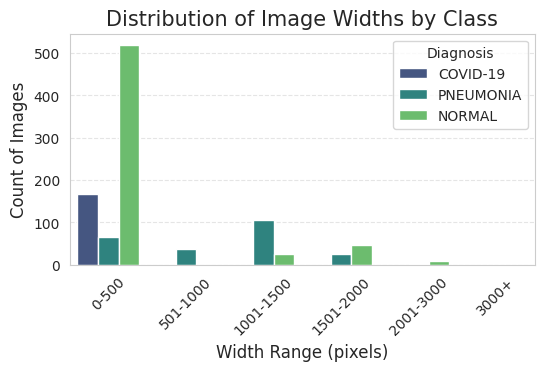

In [ ]:
def plot_width_distribution(data):
    plt.figure(figsize=(6, 3))
    sns.countplot(data=data, x='Width_Range', hue='label', palette='viridis')

    plt.title('Distribution of Image Widths by Class', fontsize=15)
    plt.xlabel('Width Range (pixels)', fontsize=12)
    plt.ylabel('Count of Images', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.legend(title='Diagnosis')
    plt.show()

# Execute using the data from the first cell
plot_width_distribution(stats_data)

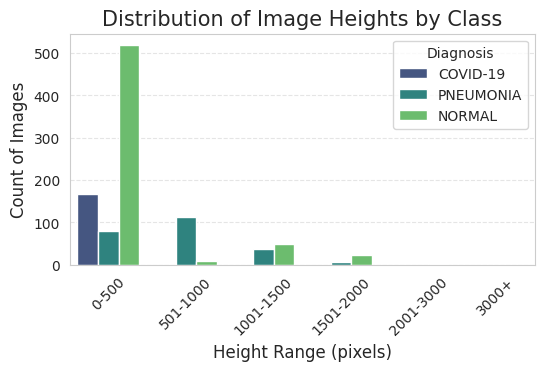

In [ ]:
def plot_height_distribution(data):
    plt.figure(figsize=(6, 3))
    sns.countplot(data=data, x='Height_Range', hue='label', palette='viridis')

    plt.title('Distribution of Image Heights by Class', fontsize=15)
    plt.xlabel('Height Range (pixels)', fontsize=12)
    plt.ylabel('Count of Images', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.legend(title='Diagnosis')
    plt.show()

# Execute using the data from the first cell
plot_height_distribution(stats_data)

### Analysis of Dimensional Distribution

The bar charts show the image size distribution in more detail. Although some high-resolution images are present, most of the dataset consists of low-resolution samples:

* **0–500px Range:** Most `NORMAL` and `COVID-19` images are within the 0–500 pixel range. For these samples, resizing to 224x224 represents a moderate reduction and maintains relevant visual information.
* **Computational Efficiency:** Most images are relatively small, so using 224x224 as the target size is efficient and helps reduce GPU memory usage and training time.



## 6. Pre-processing

This section focuses on preparing the raw data for the neural network. The pipeline includes resizing, normalization, and ... **TERMINAR**



### 6.1 Image Resizing & Global Configuration

**Objective:** Resize all images to a fixed size before training.

The selected input size is **224x224 pixels** because:

1. **Model Compatibility:** Architectures such as VGG16, ResNet, and DenseNet are commonly trained with 224x224 inputs.
2. **Resource Usage:** Smaller input dimensions reduce GPU memory consumption and training time compared to larger sizes such as 512x512.
3. **Feature Retention:** Detecting these conditions does not require extremely fine detail. The relevant patterns in chest X-rays are mostly large and diffuse, so they remain identifiable at 224x224 resolution.


**Implementation:**

The image dimensions and key hyperparameters are defined as global constants.

In [ ]:
# Image Dimensions
IMG_WIDTH = 224
IMG_HEIGHT = 224
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3) # Includes RGB channels


print(f"Global Configuration Set:")
print(f"- Target Image Size: {IMG_SIZE}")
print(f"- Input Shape: {IMG_SHAPE}")

Global Configuration Set:
- Target Image Size: (224, 224)
- Input Shape: (224, 224, 3)


#### Visual Verification of Resizing

Before applying resizing to the full dataset during training, a visual check is performed on a small sample of images.

The following code displays a grid with 5 random samples per class. This step allows verification that:

1. The aspect ratio is handled correctly and the lungs are not distorted.
2. The main anatomical structures are still visible after resizing.


Generating visual grid for target size: (224, 224)...


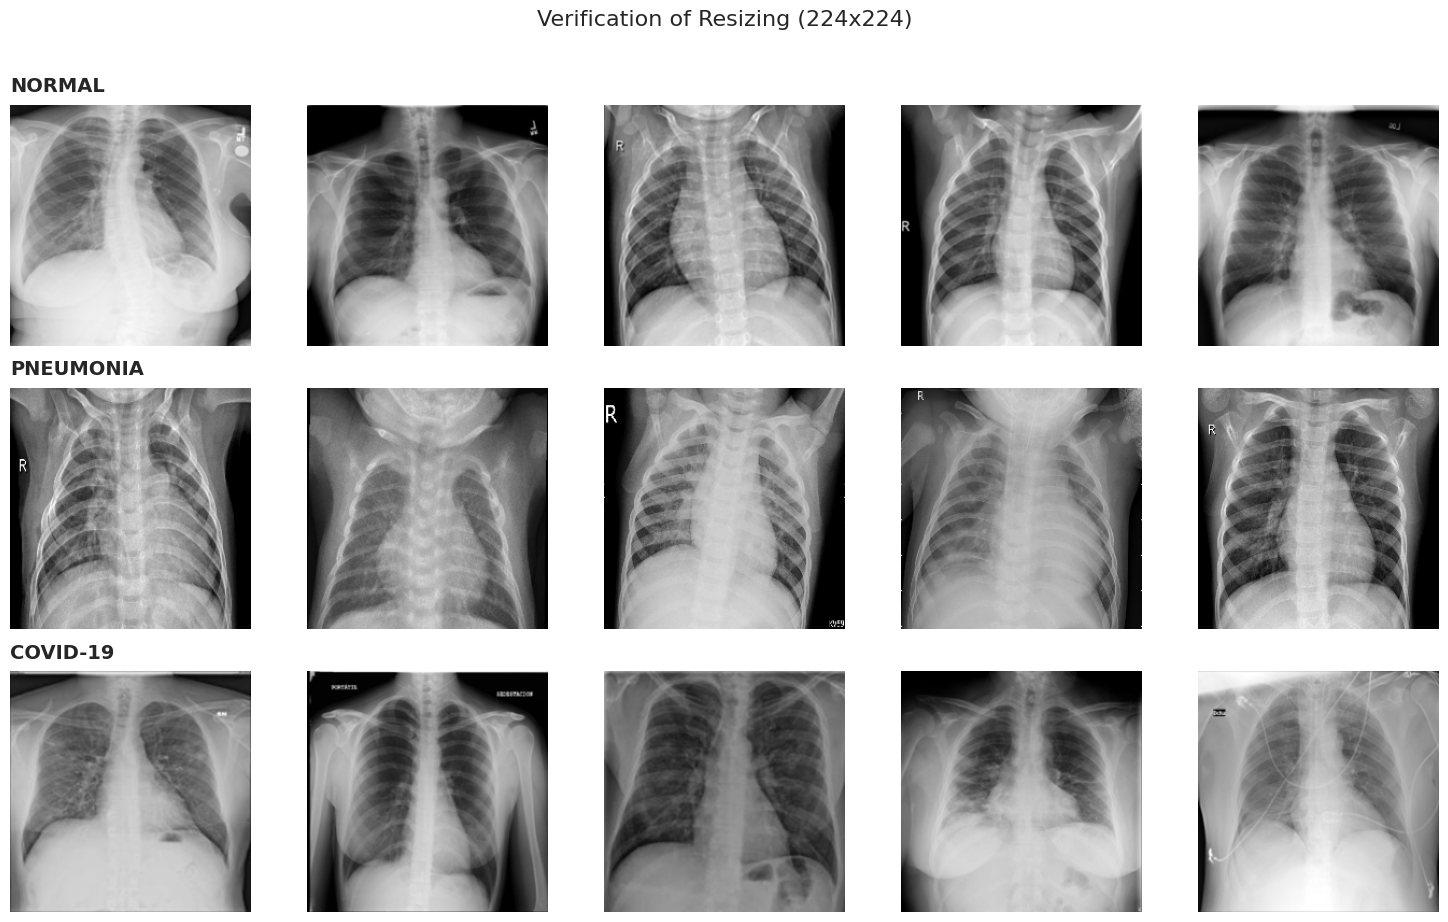

In [ ]:
import cv2
import matplotlib.pyplot as plt

def visualize_resized_samples(dataframe, categories, target_size, samples_per_category=5):
    """
    Displays a grid of random images for each specified category after resizing them.

    Args:
        dataframe (pd.DataFrame): The master dataset containing file paths.
        categories (list): List of label names to visualize
        target_size (tuple): The target (width, height) for resizing.
        samples_per_category (int): Number of images to show per class.
    """

    # Calculate grid size: Rows = number of classes, Cols = samples per class
    n_rows = len(categories)
    n_cols = samples_per_category

    # Create the figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
    plt.subplots_adjust(wspace=0.1, hspace=0.1)

    print(f"Generating visual grid for target size: {target_size}...")

    for i, category in enumerate(categories):
        # Filter the dataframe for the specific class
        class_df = dataframe[dataframe['label'] == category]

        # Take a random sample
        try:
            random_samples = class_df.sample(samples_per_category, random_state=SEED)
        except ValueError:
            random_samples = class_df # Take all if fewer than requested

        for j, (_, row) in enumerate(random_samples.iterrows()):
            img_path = row['filepath']

            # Read image using OpenCV
            img = cv2.imread(img_path)

            if img is not None:

                # REZICE
                img = cv2.resize(img, target_size)

                # Convert from BGR to RGB
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # Determine current subplot axis
                if n_rows > 1:
                    ax = axes[i, j]
                else:
                    ax = axes[j]

                # Display image
                ax.imshow(img)
                ax.axis('off') # Hide axes ticks

                # Set title only on the first image of the row
                if j == 0:
                    ax.set_title(f"{category}", fontsize=14, fontweight='bold', pad=10, loc='left')
            else:
                print(f"Could not read image at {img_path}")

    plt.suptitle(f"Verification of Resizing ({target_size[0]}x{target_size[1]})", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# Define the order of categories to inspect
target_categories = ['NORMAL', 'PNEUMONIA', 'COVID-19']

# Execute the visualization function using the Global Constant IMG_SIZE
visualize_resized_samples(df, target_categories, IMG_SIZE, samples_per_category=5)

### Analysis of Resizing Results

The resized samples (224x224) are reviewed to evaluate how the transformation affects the images:

* **Geometric Changes:** Converting rectangular images to a square format causes a vertical elongation in some cases. However, the overall chest structure remains consistent, and no important areas are cut out.
* **Pattern Visibility:** The main pathological patterns in PNEUMONIA and COVID-19 images are still visible after resizing. The reduction in size does not remove the visual cues needed for classification.
* **Conclusion:** The distortion introduced by resizing is not significant and does not affect the usability of the images.



### 6.2 Pixel Normalization

**Objective:** Scale pixel intensity values to the range [0, 1].

**Justification:**

Raw input images contain pixel values in the range [0, 255]. Dividing these values by 255 converts them to a floating-point range of [0, 1]. This transformation maintains a smaller and consistent numerical scale.

The benefits are:
1. **Numerical Stability:** Keeping pixel values between 0 and 1 avoids extremely large numbers during training, which helps maintain stable calculations.  
2. **Training Efficiency:** Normalized values make the training process smoother and more consistent, without requiring adjustments for large input values.

**Verification Method:**

A pixel intensity histogram is generated to confirm that the transformation maps the original values from [0, 255] to [0, 1] while preserving the distribution of intensities in the images.


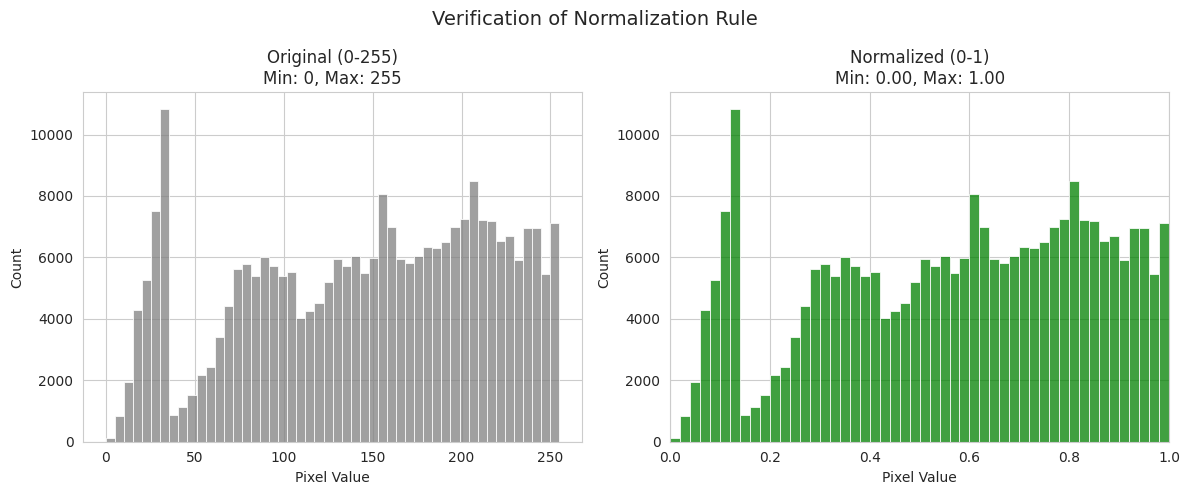

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

def verify_normalization(dataframe):
    """
    Applies the normalization rule (pixel / 255) to a random sample
    and plots the histogram.
    """
    # Pick a random image
    sample = dataframe.sample(1, random_state=SEED).iloc[0]
    img = cv2.imread(sample['filepath'])

    if img is None:
        print("Error: Could not read image.")
        return

    # Apply the normalization
    img_norm = img.astype('float32') / 255.0

    # Plot Comparison
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Histogram BEFORE
    sns.histplot(img.ravel(), bins=50, color='gray', ax=axes[0])
    axes[0].set_title(f'Original (0-255)\nMin: {img.min()}, Max: {img.max()}')
    axes[0].set_xlabel('Pixel Value')

    # Histogram AFTER
    sns.histplot(img_norm.ravel(), bins=50, color='green', ax=axes[1])
    axes[1].set_title(f'Normalized (0-1)\nMin: {img_norm.min():.2f}, Max: {img_norm.max():.2f}')
    axes[1].set_xlabel('Pixel Value')
    axes[1].set_xlim(0, 1.0)

    plt.suptitle(f"Verification of Normalization Rule", fontsize=14)
    plt.tight_layout()
    plt.show()

# Execute function
verify_normalization(df)

### Analysis of Normalization Results

The generated histograms show the effect of the pixel scaling process. The axes can be interpreted as follows:

* **X-Axis (Pixel Intensity):** Represents the brightness level of the pixels.
    * **Left side (0):** Absolute black .
    * **Right side (255 or 1.0):** Absolute white.  
* **Y-Axis (Count):** Represents the number of pixels at each intensity level.
    * Peaks indicate the most common pixel values in the image.

**Observations:**

1. **Range Shift:** Pixel values have been scaled from the original integer range [0, 255] to the float range [0.0, 1.0]. The maximum value in the normalized plot corresponds proportionally to the original maximum.  
2. **Information Preservation:** The overall distribution shape remains the same after normalization. Peaks and valleys are unchanged, meaning relative contrast and anatomical details are preserved.



### 6.3 Handling Class Imbalance

**Observation:**
The EDA revealed a class imbalance:
* **NORMAL:** ~11,775 images (Majority)
* **PNEUMONIA:** ~5,618 images
* **COVID-19:** ~3.916 images


(**COMPLETAR DESCRIPCION DE PASOS**)




### Strategy A: Undersampling

An undersampling is applied to reduce the bias introduced by the large number of `NORMAL` images.

The `NORMAL` class is randomly downsampled to match the number of samples in the `PNEUMONIA` class (5,618).

This adjustment reduces the gap between the healthy and disease classes. By limiting the excess of normal samples.


In [ ]:
from sklearn.utils import shuffle

def undersampling(dataframe, target_class='NORMAL', target_count=5618):
    """
    Creates a new dataframe where the specified majority class is downsampled
    to a specific number.

    Args:
        dataframe: The original dataset.
        target_class (str): The label of the class to be reduced.
        target_count (int): The number of samples to keep for the target class.

    Returns:
        A new dataframe with the reduced class.
    """
    # Isolate the class to be reduced
    df_target = dataframe[dataframe['label'] == target_class]

    # Isolate the other classes
    df_others = dataframe[dataframe['label'] != target_class]

    # Randomly sample the target class
    if len(df_target) > target_count:
        df_target_downsampled = df_target.sample(n=target_count, random_state=SEED)
    else:
        df_target_downsampled = df_target

    # Concatenate and Shuffle
    df_result = pd.concat([df_target_downsampled, df_others])
    df_result = shuffle(df_result, random_state=SEED).reset_index(drop=True)

    return df_result

# Execute

print("Applying Undersampling...")
df_undersampling = undersampling(df, target_class='NORMAL', target_count=5618)

# Verification
print("\n" + "="*40)
print("Original Dataset distribution:")
print(df['label'].value_counts())
print("-" * 40)
print("Undersampled Dataset distribution:")
print(df_undersampling['label'].value_counts())
print("="*40)

Applying Undersampling...

Original Dataset distribution:
label
NORMAL       11775
PNEUMONIA     5618
COVID-19      3616
Name: count, dtype: int64
----------------------------------------
Undersampled Dataset distribution:
label
NORMAL       5618
PNEUMONIA    5618
COVID-19     3616
Name: count, dtype: int64


### Analysis of Undersampling Results

The execution of the moderate undersampling strategy resulted in the experimental dataset (`df_undersampling`) having the following distribution:

* **NORMAL:** ~5,618 samples (reduced from ~11,700)  
* **PNEUMONIA:** ~5,618 samples (unchanged)  
* **COVID-19:** ~3,616 samples (unchanged)  

By aligning the `NORMAL` class with `PNEUMONIA`, the excess of healthy images is reduced. This limits the dominance of the majority class during training and allows a more balanced comparison between healthy and pathological cases. `PNEUMONIA` and `COVID-19` samples are preserved.

An alternative approach would have been to enforce a 1:1:1 balance by reducing every class to ~3,616 samples. This option was not applied because it would require removing approximately 2,000 pneumonia images. Pathological data is limited and important for learning disease patterns, so it is retained. The resulting imbalance (1.5:1) is moderate.




### 6.3 Strategy B: Class Weighting

Class weighting is applied to handle class imbalance while keeping the original dataset of 21,009 images unchanged.

The dataset distribution is not modified. Instead, different weights are assigned to each class in the loss function during training. Errors in minority classes receive a higher penalty than errors in majority classes. This makes the model pay more attention to underrepresented classes, such as COVID-19.

Weights are assigned using the formula:

**W_j = N_total / (N_classes × N_j)**

Where:
- N_total is the total number of samples.
- N_classes is the number of classes (3).
- N_j is the number of samples in class j.

**Implementation Details (class_weight='balanced'):**

To implement this weighting scheme, the `compute_class_weight` function from Scikit-Learn is used with the parameter `class_weight='balanced'`.

Three configuration options were considered when assigning class weights: None, a manual dictionary, and 'balanced'. The `'balanced'` option was selected because it calculates the weights based on how many samples each class has. In this way, classes with fewer images receive higher weights, and classes with more images receive lower weights, without requiring manual adjustments.


The default option (None) leaves all classes with equal weight, which would keep the original imbalance unchanged during training.

A manual dictionary (for example, {0:1, 1:50}) allows custom weights, but it depends on subjective choices and it doesn´t reflect the real class proportions in the dataset.




In [ ]:
from sklearn.utils import class_weight
import numpy as np

def calculate_class_weights(dataframe):
    """
    Computes the weights for each class to balance the loss function.
    """
    # Extract the label column
    labels = dataframe['label']

    # Get unique classes(sorted alphabetically)
    classes = np.unique(labels)

    # Compute weights using the balanced heuristic
    # This applies the formula: n_samples / (n_classes * n_samples_in_class)
    weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=classes,
        y=labels
    )

    # Create a dictionary mapping Class Index -> Weight (model.fit() format)
    class_weight_dict = dict(enumerate(weights))

    return class_weight_dict, classes

# Execute
print("Calculating Class Weights...")

weights_dict, class_names = calculate_class_weights(df)

# Verification
print("\n" + "="*60)
print(f"Total Samples: {len(df)}")
print(f"Classes: {class_names}")
print("-" * 60)
print("Computed Weights:")
for i, label in enumerate(class_names):
    count = len(df[df['label'] == label])
    weight = weights_dict[i]
    print(f"Class '{label}' ({count} images): \tWeight = {weight:.4f}")
print("="*60)

Calculating Class Weights...

Total Samples: 21009
Classes: ['COVID-19' 'NORMAL' 'PNEUMONIA']
------------------------------------------------------------
Computed Weights:
Class 'COVID-19' (3616 images): 	Weight = 1.9367
Class 'NORMAL' (11775 images): 	Weight = 0.5947
Class 'PNEUMONIA' (5618 images): 	Weight = 1.2465


### Analysis of Class Weighting Results

The calculated weights show how the `'balanced'` option adjusts for class imbalance. Classes with fewer samples receive higher weights, while classes with more samples receive lower weights:

* **COVID-19 (Class 0):** Minority class (3,616 images), weight = 1.94  
* **NORMAL (Class 1):** Majority class (11,775 images), weight = 0.59  
* **PNEUMONIA (Class 2):** Intermediate class (5,618 images), weight = 1.25  

During training, these weights are applied in the loss function.


**Index Mapping:**  
The weight dictionary uses numeric indices (`0, 1, 2`) instead of the class names because the model represents class labels as integers. The assignment of indices follows alphabetical order.



**Strategy C: Data augmentation**    
**COMPLETAR**

### Preparación de datasets


###Organizing images into structured dataset

Reorganize the image files into a structured directory format suitable for deep learning frameworks such as TensorFlow and Keras.

The original dataset contains image file paths and labels stored in a DataFrame. However, functions like image_dataset_from_directory() require a specific folder structure where images are grouped into subdirectories according to their class labels.

In [ ]:
#Organizing directories in dataset structure
import os
import shutil
from tqdm.notebook import tqdm

# 1. Define the destiny directory
output_dir = "dataset"

# 2. if doesn't exist, created it
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Directory '{output_dir}' created.")
else:
    print(f"The directory '{output_dir}' already exists. Verify it is empty.")

# 3. Iterate through the DataFrame to organize files
print("Organizing images into class-based folders...")

for index, row in tqdm(df.iterrows(), total=len(df)):
    src_path = row['filepath']  # Original path
    label = row['label']        # Original label (COVID-19, NORMAL, etc.)

    # Name of the file
    filename = os.path.basename(src_path)

    # Create class directory (ex: dataset/COVID-19)
    class_dir = os.path.join(output_dir, label)
    os.makedirs(class_dir, exist_ok=True)

    # Define the new destination path
    dst_path = os.path.join(class_dir, filename)

    # Only copy the file if it doesn't already exist
    if not os.path.exists(dst_path):
        try:
            shutil.copy(src_path, dst_path)
        except Exception as e:
            print(f"Error copiando {src_path}: {e}")

print("\nDataset folder structure successfully created.")

La carpeta 'dataset' ya existe. Verifica si está vacía.
Organizando imágenes en carpetas por clase...


  0%|          | 0/21009 [00:00<?, ?it/s]


¡Listo! Estructura de archivos creada correctamente.


### Loading and Preparing the Image Dataset

In this step, is needed to load the organized image dataset from disk and prepare it for training and validation using TensorFlow’s **image_dataset_from_directory()** utility.

This function automatically reads images from a structured directory where each subfolder represents a class label. It also assigns labels based on folder names and returns a tf.data.Dataset object ready for model training. This function helps to perform actions such as:
1.   **Split the dataset:** separate percentages of the images for training (80%) and validation (20%)
2.   **Setting a seed:** used for reproducibility of the split.
3.   **Image resizing:** All images are automatically resized to (224, 224)
4.   **Batching:** Images are grouped into batches of size 32, instead of loading all images into memory.
5.   **Shuffling:** Training data is shuffled to improve generalization. Is not necessary to shuffle the validation data to ensure consistent evaluation.
6.  **Change the color mode:** Convert images to grayscale during loading.

Performance optimization is also used with the function **.prefetch(buffer_size= tf.data.AUTOTUNE)**, allowing TensorFlow to load the next batch while the current one is being processed, improving training efficiency and reduces input pipeline bottlenecks.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, GlobalAveragePooling2D, Rescaling

# 1. Data loading
# Read all the images from the disk directory.
print("loading datasets from the directory...")

train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory="dataset",        # Directory path
    validation_split=0.2,       # 20% of the data will be used for validation
    subset="training",          # Select the training portion (80%)
    seed=42,                    # Seed ensures reproducibility of the split
    image_size=IMG_SIZE,        # Resize the images to (224, 224)
    batch_size=BATCH_SIZE,      # 32 images per batch
    shuffle=True                # Shuffle training data to improve generalization
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    directory="dataset",
    validation_split=0.2,       # Same split percentage as training
    subset="validation",        # Select the validation portion (20%)
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False               # Validation data is not shuffled to ensure stable evaluation
)

# Prefetch allows the model to prepare the next batch while the current one is being processed
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

Cargando datasets desde el directorio...
Found 21009 files belonging to 3 classes.
Using 16808 files for training.
Found 21009 files belonging to 3 classes.
Using 4201 files for validation.


In [ ]:
print("\nCalculating weight of the classes...")
weights_dict, _ = calculate_class_weights(df)
print(f"Weights applied: {weights_dict}")


Calculando pesos de clase...
Pesos aplicados: {0: np.float64(1.936670353982301), 1: np.float64(0.5947346072186837), 2: np.float64(1.2465290138839444)}


### 7. CNN Architecture  

This **Convolutional Neural Network (CNN)** is designed to extract **features** from chest X-ray images and classify them into three categories: **Normal**, **COVID-19**, and **Pneumonia**. The model follows a standard from **feature extraction** to **classification**.

* **Input**: Chest X-ray images with a shape of **224 × 224 pixels**.

* **Rescaling Layer**: A **normalization** step is applied to rescale pixel values. This improves **training stability** and enables **faster convergence** during optimization.

* **Feature Extraction**:  
  The model uses **convolutional layers (Conv2D)** with a **3 × 3 kernel size**. The first layers include **32 filters** to capture basic patterns such as edges and textures, while deeper layers use **64 filters** to learn more **complex features**.  
  **Max Pooling (2 × 2)** is applied to reduce the **spatial dimensions**, allowing the network to focus on the most **relevant features** while reducing computational cost.

* **Regularization**:  
  A **Dropout layer (20%)** is included to reduce **overfitting** by randomly deactivating 20% of the neurons during training.  
  Instead of using **Flatten**, the model applies **Global Average Pooling**, which computes the **average of each feature map**. This significantly reduces the number of parameters and helps improve **generalization**.

* **Classification (Fully Connected Layers)**:  
  A **Dense hidden layer** combines the extracted features and learns **complex relationships** between them.  
  Finally, the output layer uses a **Softmax activation function** to produce a **probability distribution** across the three classes.


In [ ]:
# Libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, GlobalAveragePooling2D, Rescaling

# Defines a linear stack of layers where data flows in order from input to output.
model = Sequential()

# Normalization: Scales pixel values from [0, 255] to [0, 1]
model.add(Rescaling(1./255, input_shape=(224, 224, 3)))

# First Convolutional Block: Extracts basic features using 32 filters.
model.add(Conv2D(32, (3, 3), activation='relu'))
# MaxPooling: Reduces the spatial dimensions of the feature maps.
model.add(MaxPooling2D(pool_size=(2, 2)))
# Second Convolutional Block: Extracts basic features using 32 filters.
model.add(Conv2D(32, (3, 3), activation='relu'))
# MaxPooling: Reduces the spatial dimensions of the feature maps.
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third Convolutional Block: Learns more complex patterns
model.add(Conv2D(64, (3, 3), activation='relu'))
# MaxPooling: Further downsamples the data to focus on high-level features.
model.add(MaxPooling2D(pool_size=(2, 2)))
# Fourth Convolutional Block: Learns more complex patterns
model.add(Conv2D(64, (3, 3), activation='relu'))
# MaxPooling: Further downsamples the data to focus on high-level features.
model.add(MaxPooling2D(pool_size=(2, 2)))

# Dropout: A regularization technique that randomly shuts down 20% of neurons during training.
model.add(Dropout(0.2))

# GlobalAveragePooling2D: Replaces the traditional "Flatten" layer.
model.add(GlobalAveragePooling2D())

# Fully Connected (Dense) Layer: Combines all extracted features to interpret the data.
model.add(Dense(32, activation='relu'))

# Dropout for Optimization: Additional regularization before the final decision.
model.add(Dropout(0.2))

# Output Layer: Uses 'softmax' to provide a probability distribution for the 3 classes (NORMAL, COVID-19, and PNEUMONIA)
model.add(Dense(3, activation='softmax'))

In [ ]:

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,715 (252.80 KB)

 Trainable params: 21,571 (84.26 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 43,144 (168.54 KB)

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
print("\nTraining...")
history = model.fit(
    train_dataset,
    epochs=15,
    validation_data=validation_dataset,
    class_weight=weights_dict
)


Iniciando entrenamiento...
Epoch 1/15
526/526 ━━━━━━━━━━━━━━━━━━━━ 82s 145ms/step - accuracy: 0.3358 - loss: 1.0913 - val_accuracy: 4.7608e-04 - val_loss: 1.1341
Epoch 2/15
526/526 ━━━━━━━━━━━━━━━━━━━━ 74s 141ms/step - accuracy: 0.5097 - loss: 0.9933 - val_accuracy: 0.9114 - val_loss: 0.5714
Epoch 3/15
526/526 ━━━━━━━━━━━━━━━━━━━━ 73s 139ms/step - accuracy: 0.6371 - loss: 0.7593 - val_accuracy: 0.9850 - val_loss: 0.1353
Epoch 4/15
526/526 ━━━━━━━━━━━━━━━━━━━━ 83s 158ms/step - accuracy: 0.6523 - loss: 0.6878 - val_accuracy: 0.9852 - val_loss: 0.1240
Epoch 5/15
526/526 ━━━━━━━━━━━━━━━━━━━━ 75s 143ms/step - accuracy: 0.6638 - loss: 0.6575 - val_accuracy: 0.9207 - val_loss: 0.3032
Epoch 6/15
526/526 ━━━━━━━━━━━━━━━━━━━━ 69s 132ms/step - accuracy: 0.6745 - loss: 0.6330 - val_accuracy: 0.9557 - val_loss: 0.1816
Epoch 7/15
526/526 ━━━━━━━━━━━━━━━━━━━━ 69s 131ms/step - accuracy: 0.6810 - loss: 0.6201 - val_accuracy: 0.9005 - val_loss: 0.2979
Epoch 8/15
526/526 ━━━━━━━━━━━━━━━━━━━━ 69s 131ms/s

Evaluando modelo...
132/132 ━━━━━━━━━━━━━━━━━━━━ 16s 118ms/step - accuracy: 0.9535 - loss: 0.1540

Resultados Finales:
Loss (Error): 0.1472
Accuracy (Precisión): 95.14%


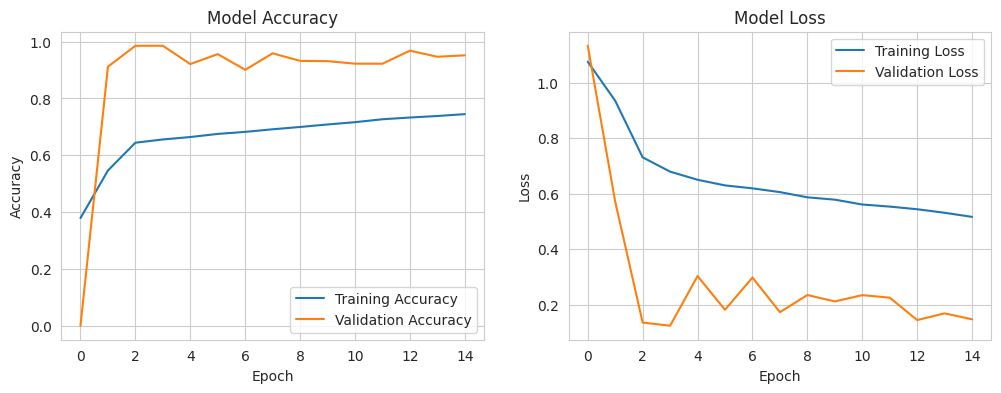

In [ ]:
import matplotlib.pyplot as plt

# 1. Model evaluation
# Evaluate the model using the validation dataset.
# This dataset was not used for learning.
print("Evaluating model...")
loss, accuracy = model.evaluate(validation_dataset, verbose=1)

print(f'\nFinal Results:')
print(f'Loss: {loss:.4f}')
print(f'Accuracy: {accuracy*100:.2f}%')

# 2. Training history plots
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()


In [ ]:
# Saving model .keras
model.save('modelo_covid_estrategia_b.keras')
print("Succesfully saved.")

Modelo guardado exitosamente.
